In [47]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json  

results_dir = "HW4results"
os.makedirs(results_dir, exist_ok=True)

Epsilon-Greedy (epsilon=0.1): Converged in 41 episodes.


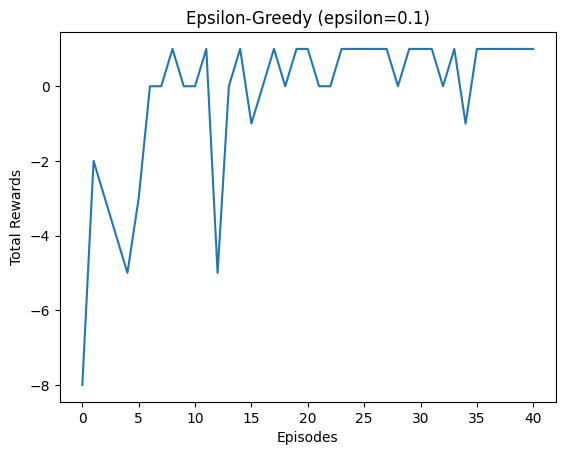

Epsilon-Greedy (epsilon=0.2): Converged in 81 episodes.


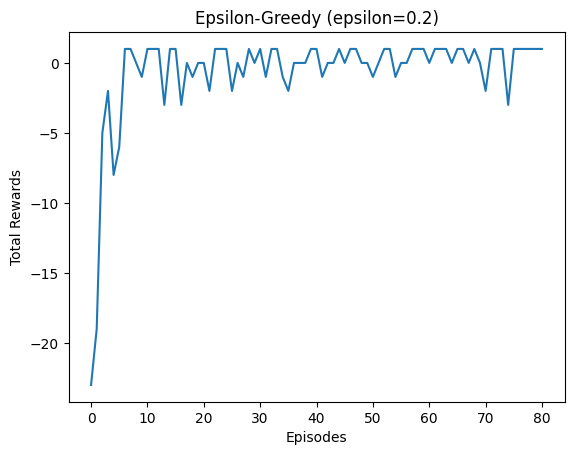

Epsilon-Greedy (epsilon=0.3): Converged in 172 episodes.


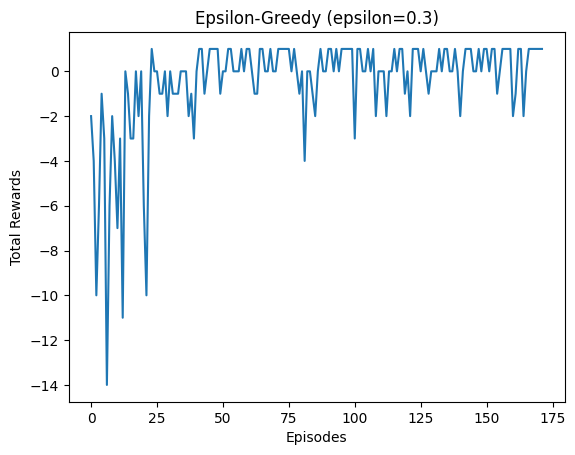

Boltzmann (T=2000, Decay=0.995): Converged in 0 episodes.


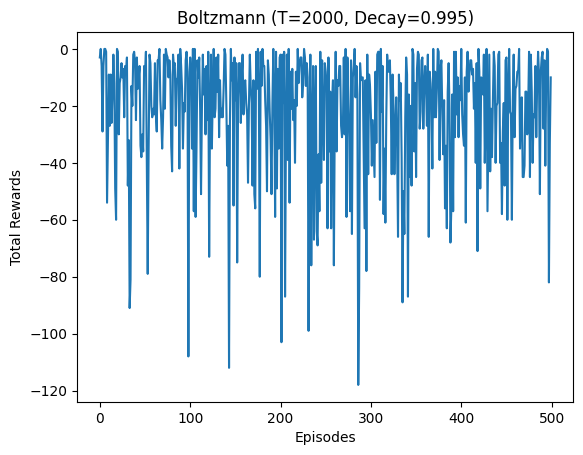

Boltzmann (T=1000, Decay=0.999): Converged in 0 episodes.


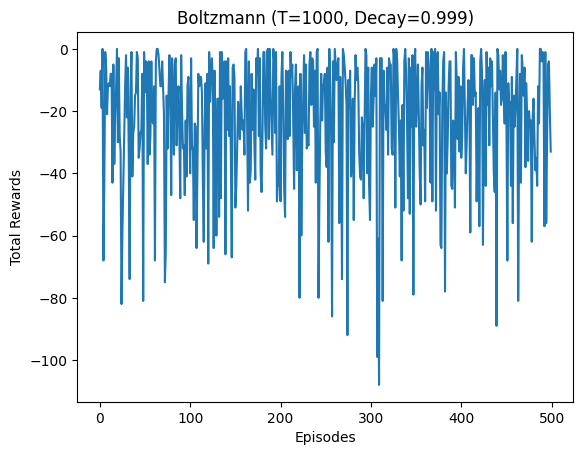

Boltzmann (T=500, Decay=0.98): Converged in 0 episodes.


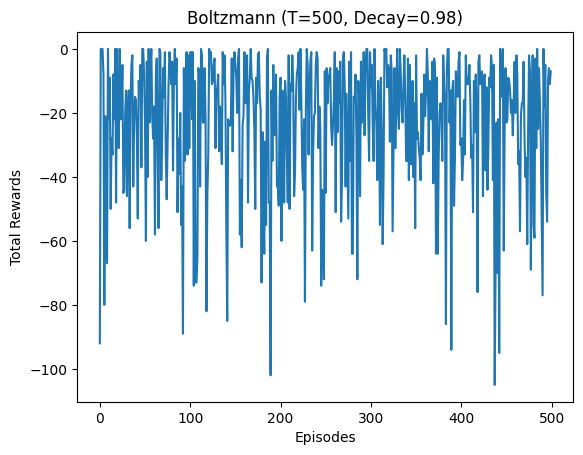

In [77]:
import numpy as np
import matplotlib.pyplot as plt

class FunGridWorld:
    """Welcome to the FunGridWorld: Where walls block, rewards pop, and agents wander!"""
    def __init__(self):
        self.grid_height = 10
        self.grid_width = 10
        self.map_layout = np.zeros((self.grid_height, self.grid_width))
        self.agent_position = (0, 0)  # Starting at the top left corner—adventurous, huh?

        # Rewards and obstacles: Gold is great, red zones are bad, and walls... just walls.
        self.goal_state = (5, 5)
        self.bad_zones = [(3, 3), (4, 5), (4, 6), (5, 6), (5, 8), (6, 8), (7, 3), (7, 5), (7, 6)]
        self.walls = [(2, 1), (2, 2), (2, 3), (2, 4), (2, 6), (2, 7), (2, 8), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4)]

        # The layout: Goals are +1, bad zones are -1, walls are walls (unchangeable).
        self.map_layout[self.goal_state] = 1
        for x, y in self.bad_zones:
            self.map_layout[x, y] = -1

        self.moves = ['UP', 'DOWN', 'LEFT', 'RIGHT']  # Our action arsenal!
        self.end_states = [self.goal_state]

    def get_possible_moves(self):
        """Return the moves our agent can take—choose wisely!"""
        return self.moves

    def show_agent(self):
        """Display the grid with the agent's current location—center stage!"""
        view = np.zeros((self.grid_height, self.grid_width))
        view[self.agent_position] = 1
        return view

    def fetch_reward(self, position):
        """What does this spot have to offer? Gold, doom, or meh?"""
        return self.map_layout[position]

    def take_action(self, move):
        """Make a move... and hope it's a good one."""
        x, y = self.agent_position
        new_position = self.agent_position

        if move == 'UP' and x > 0:
            new_position = (x - 1, y)
        elif move == 'DOWN' and x < self.grid_height - 1:
            new_position = (x + 1, y)
        elif move == 'LEFT' and y > 0:
            new_position = (x, y - 1)
        elif move == 'RIGHT' and y < self.grid_width - 1:
            new_position = (x, y + 1)

        if new_position not in self.walls:
            self.agent_position = new_position

        return self.fetch_reward(self.agent_position)

    def is_finished(self):
        """Are we there yet? Check if the goal has been reached."""
        return self.agent_position in self.end_states


def smart_boltzmann(q_map, state, temp):
    """Boltzmann policy: Hot-headed exploration or cool-headed exploitation."""
    q_vals = np.array([q_map[state][action] for action in ["UP", "DOWN", "LEFT", "RIGHT"]])
    max_q = np.max(q_vals)
    exp_vals = np.exp((q_vals - max_q) / max(temp, 1e-3))  # Stability trick!
    probabilities = exp_vals / np.sum(exp_vals)
    options = ["UP", "DOWN", "LEFT", "RIGHT"]
    return np.random.choice(options, p=probabilities)


class SmartQLearner:
    """An agent with big dreams and Q-values to make them come true."""
    def __init__(self, world, alpha=0.01, beta=0.9, exploration_rate=0.1, boltz_mode=False, temp=1000):
        self.world = world
        self.q_values = { (x, y): {move: 0.0 for move in ["UP", "DOWN", "LEFT", "RIGHT"]} 
                         for x in range(world.grid_height) 
                         for y in range(world.grid_width) 
                         if (x, y) not in world.walls }
        self.alpha = alpha  # Learning rate, because slow and steady wins the race!
        self.beta = beta    # Discount factor, for long-term rewards.
        self.exploration_rate = exploration_rate
        self.boltz_mode = boltz_mode
        self.temp = temp

    def choose_move(self):
        """Decide to explore or exploit—life is all about balance."""
        if self.boltz_mode:
            return smart_boltzmann(self.q_values, self.world.agent_position, self.temp)
        elif np.random.rand() < self.exploration_rate:
            return np.random.choice(self.world.get_possible_moves())
        else:
            actions = self.q_values[self.world.agent_position]
            best_value = max(actions.values())
            return np.random.choice([act for act, val in actions.items() if val == best_value])

    def update_q(self, state, action, reward, next_state):
        """Update the Q-value: Because learning is key to survival."""
        future_q = max(self.q_values[next_state].values())
        self.q_values[state][action] += self.alpha * (reward + self.beta * future_q - self.q_values[state][action])


def train_q_agent(world, agent, episodes=500, max_steps=1000, temp_decay=0.9):
    """Train the agent and count the rewards... or punishments."""
    reward_log = []
    last_reward = 0
    stable_count = 0
    stable_threshold = 5
    convergence_episode = 0

    for ep in range(episodes):
        total_reward = 0
        world.agent_position = (0, 0)  # Reset the agent's position
        step_count = 0

        while not world.is_finished() and step_count < max_steps:
            current_pos = world.agent_position
            move = agent.choose_move()
            reward = world.take_action(move)
            new_pos = world.agent_position

            agent.update_q(current_pos, move, reward, new_pos)
            total_reward += reward
            step_count += 1

        reward_log.append(total_reward)

        # Adjust temperature for Boltzmann explorers
        if agent.boltz_mode and ep % 100 == 0:
            agent.temp *= temp_decay

        # Check if rewards have stabilized
        if abs(total_reward - last_reward) < 1e-2:
            stable_count += 1
        else:
            stable_count = 0

        if stable_count >= stable_threshold:
            convergence_episode = ep + 1
            break

        last_reward = total_reward

    return reward_log, convergence_episode


def plot_rewards(reward_list, graph_title):
    """Plot the ups and downs of learning."""
    plt.plot(reward_list)
    plt.xlabel("Episodes")
    plt.ylabel("Total Rewards")
    plt.title(graph_title)
    plt.show()


def main():
    """Run experiments: Epsilon-Greedy vs. Boltzmann—who wins?"""
    world = FunGridWorld()

    # Epsilon-Greedy Experiments
    for eps in [0.1, 0.2, 0.3]:
        learner = SmartQLearner(world, exploration_rate=eps)
        rewards, convergence = train_q_agent(world, learner)
        print(f"Epsilon-Greedy (epsilon={eps}): Converged in {convergence} episodes.")
        plot_rewards(rewards, f"Epsilon-Greedy (epsilon={eps})")

#     # Boltzmann Exploration Experiments
#     for initial_temp in [2000, 500]:
#         learner = SmartQLearner(world, boltz_mode=True, temp=initial_temp)
#         rewards, convergence = train_q_agent(world, learner, temp_decay=0.995)
#         print(f"Boltzmann (T={initial_temp}): Converged in {convergence} episodes.")
#         plot_rewards(rewards, f"Boltzmann (T={initial_temp})")

    for initial_temp, decay in [(2000, 0.995), (1000, 0.999), (500, 0.98)]:
        learner = SmartQLearner(world, boltz_mode=True, temp=initial_temp)
        rewards, convergence = train_q_agent(world, learner, temp_decay=decay)
        print(f"Boltzmann (T={initial_temp}, Decay={decay}): Converged in {convergence} episodes.")
        plot_rewards(rewards, f"Boltzmann (T={initial_temp}, Decay={decay})")

if __name__ == "__main__":
    main()



Convergence achieved after 52 episodes!

Converged Q-Values:
State (0, 0):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000

State (0, 1):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000

State (0, 2):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000

State (0, 3):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000

State (0, 4):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000

State (0, 5):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000

State (0, 6):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Act

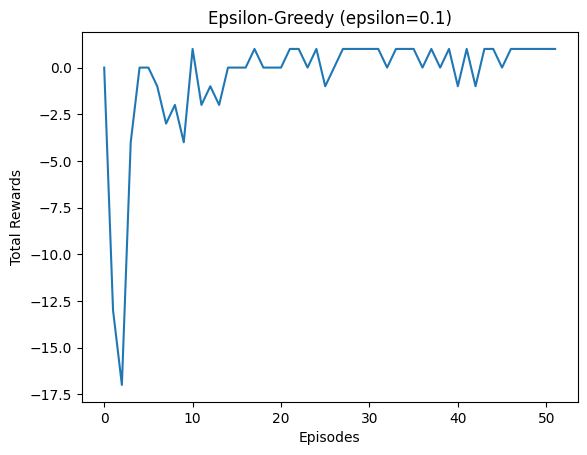


Converged Q-Values for Each State-Action Pair:
State (0, 0):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 1):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 2):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 3):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 4):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 5):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 6):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value =

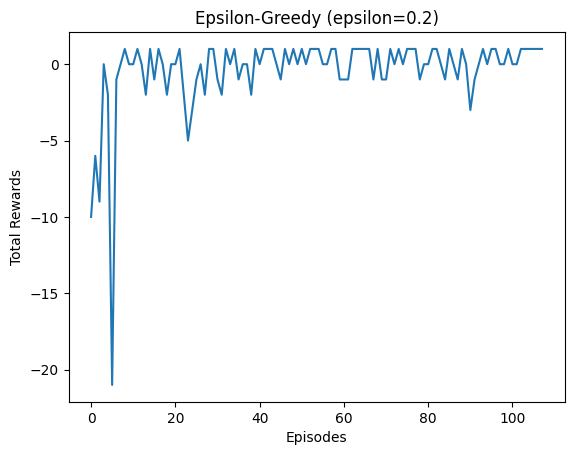


Converged Q-Values for Each State-Action Pair:
State (0, 0):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 1):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 2):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 3):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 4):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 5):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 6):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value =

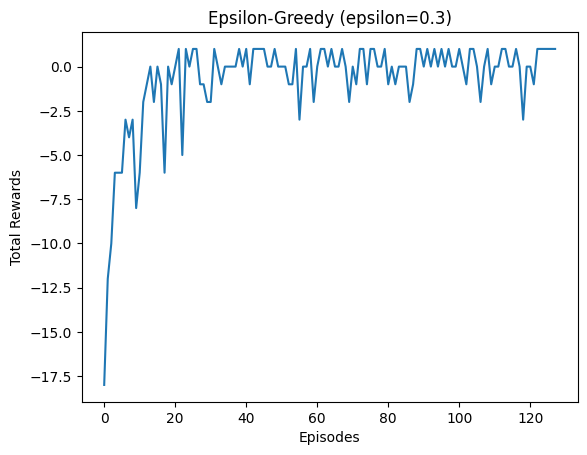


Converged Q-Values for Each State-Action Pair:
State (0, 0):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 1):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 2):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 3):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 4):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 5):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 6):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value =

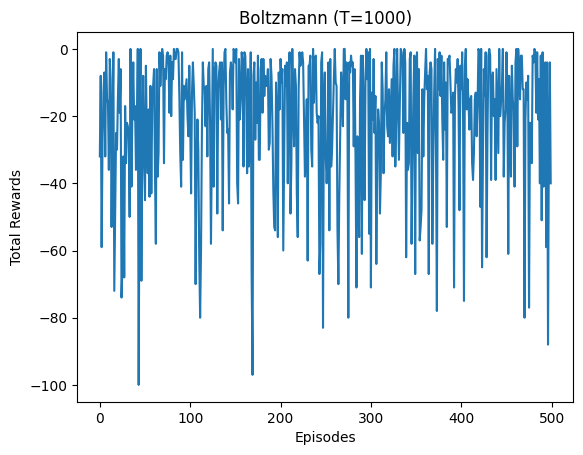


Converged Q-Values for Each State-Action Pair:
State (0, 0):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 1):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 2):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 3):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 4):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 5):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 6):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value =

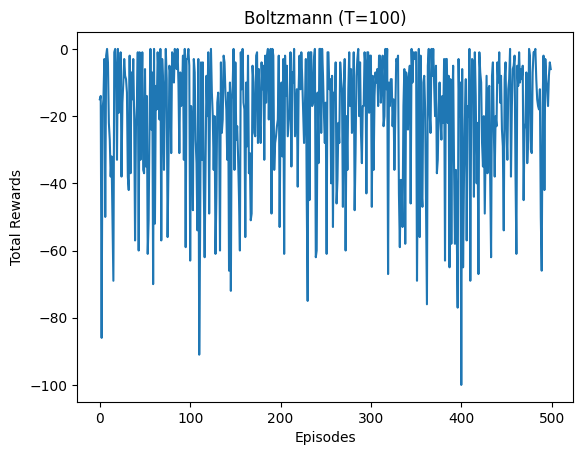


Converged Q-Values for Each State-Action Pair:
State (0, 0):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 1):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 2):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 3):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 4):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 5):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value = 0.000
State (0, 6):
  Action UP: Q-value = 0.000
  Action DOWN: Q-value = 0.000
  Action LEFT: Q-value = 0.000
  Action RIGHT: Q-value =

In [82]:
import numpy as np
import matplotlib.pyplot as plt

class FunGridWorld:
    """Welcome to the FunGridWorld: Where walls block, rewards pop, and agents wander!"""
    def __init__(self):
        self.grid_height = 10
        self.grid_width = 10
        self.map_layout = np.zeros((self.grid_height, self.grid_width))
        self.agent_position = (0, 0)  # Starting at the top left corner—adventurous, huh?

        # Rewards and obstacles: Gold is great, red zones are bad, and walls... just walls.
        self.goal_state = (5, 5)
        self.bad_zones = [(3, 3), (4, 5), (4, 6), (5, 6), (5, 8), (6, 8), (7, 3), (7, 5), (7, 6)]
        self.walls = [(2, 1), (2, 2), (2, 3), (2, 4), (2, 6), (2, 7), (2, 8), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4)]

        # The layout: Goals are +1, bad zones are -1, walls are walls (unchangeable).
        self.map_layout[self.goal_state] = 1
        for x, y in self.bad_zones:
            self.map_layout[x, y] = -1

        self.moves = ['UP', 'DOWN', 'LEFT', 'RIGHT']  # Our action arsenal!
        self.end_states = [self.goal_state]

    def get_possible_moves(self):
        """Return the moves our agent can take—choose wisely!"""
        return self.moves

    def show_agent(self):
        """Display the grid with the agent's current location—center stage!"""
        view = np.zeros((self.grid_height, self.grid_width))
        view[self.agent_position] = 1
        return view

    def fetch_reward(self, position):
        """What does this spot have to offer? Gold, doom, or meh?"""
        return self.map_layout[position]

    def take_action(self, move):
        """Make a move... and hope it's a good one."""
        x, y = self.agent_position
        new_position = self.agent_position

        if move == 'UP' and x > 0:
            new_position = (x - 1, y)
        elif move == 'DOWN' and x < self.grid_height - 1:
            new_position = (x + 1, y)
        elif move == 'LEFT' and y > 0:
            new_position = (x, y - 1)
        elif move == 'RIGHT' and y < self.grid_width - 1:
            new_position = (x, y + 1)

        if new_position not in self.walls:
            self.agent_position = new_position

        return self.fetch_reward(self.agent_position)

    def is_finished(self):
        """Are we there yet? Check if the goal has been reached."""
        return self.agent_position in self.end_states


def smart_boltzmann(q_map, state, temp):
    """Boltzmann policy: Hot-headed exploration or cool-headed exploitation."""
    q_vals = np.array([q_map[state][action] for action in ["UP", "DOWN", "LEFT", "RIGHT"]])
    max_q = np.max(q_vals)
    exp_vals = np.exp((q_vals - max_q) / max(temp, 1e-2))  # Stability trick!
    probabilities = exp_vals / np.sum(exp_vals)
    options = ["UP", "DOWN", "LEFT", "RIGHT"]
    return np.random.choice(options, p=probabilities)


class SmartQLearner:
    """An agent with big dreams and Q-values to make them come true."""
    def __init__(self, world, alpha=0.01, beta=0.9, exploration_rate=0.1, boltz_mode=False, temp=1000):
        self.world = world
        self.q_values = { (x, y): {move: 0.0 for move in ["UP", "DOWN", "LEFT", "RIGHT"]} 
                         for x in range(world.grid_height) 
                         for y in range(world.grid_width) 
                         if (x, y) not in world.walls }
        self.alpha = alpha  # Learning rate, because slow and steady wins the race!
        self.beta = beta    # Discount factor, for long-term rewards.
        self.exploration_rate = exploration_rate
        self.boltz_mode = boltz_mode
        self.temp = temp

    def choose_move(self):
        """Decide to explore or exploit—life is all about balance."""
        if self.boltz_mode:
            return smart_boltzmann(self.q_values, self.world.agent_position, self.temp)
        elif np.random.rand() < self.exploration_rate:
            return np.random.choice(self.world.get_possible_moves())
        else:
            actions = self.q_values[self.world.agent_position]
            best_value = max(actions.values())
            return np.random.choice([act for act, val in actions.items() if val == best_value])

    def update_q(self, state, action, reward, next_state):
        """Update the Q-value: Because learning is key to survival."""
        future_q = max(self.q_values[next_state].values())
        self.q_values[state][action] += self.alpha * (reward + self.beta * future_q - self.q_values[state][action])


def display_q_values(q_table):
    """Display Q-values for all state-action pairs in a readable format."""
    print("\nConverged Q-Values:")
    for state, actions in sorted(q_table.items()):
        print(f"State {state}:")
        for action, value in actions.items():
            print(f"  Action {action}: Q-value = {value:.3f}")
        print()


def train_q_agent(world, agent, episodes=500, max_steps=1000, temp_decay=0.9):
    """Train the agent and count the rewards... or punishments."""
    reward_log = []
    last_reward = 0
    stable_count = 0
    stable_threshold = 5
    convergence_episode = 0

    for ep in range(episodes):
        total_reward = 0
        world.agent_position = (0, 0)  # Reset the agent's position
        step_count = 0

        while not world.is_finished() and step_count < max_steps:
            current_pos = world.agent_position
            move = agent.choose_move()
            reward = world.take_action(move)
            new_pos = world.agent_position

            agent.update_q(current_pos, move, reward, new_pos)
            total_reward += reward
            step_count += 1

        reward_log.append(total_reward)

        # Adjust temperature for Boltzmann explorers
        if agent.boltz_mode and ep % 100 == 0:
            agent.temp *= temp_decay

        # Check if rewards have stabilized
        if abs(total_reward - last_reward) < 1e-2:
            stable_count += 1
        else:
            stable_count = 0

        if stable_count >= stable_threshold:
            convergence_episode = ep + 1
            print(f"\nConvergence achieved after {convergence_episode} episodes!")
            display_q_values(agent.q_values)
            break

        last_reward = total_reward

    if convergence_episode == 0:  # If no convergence detected
        print("\nNo convergence detected within the given episodes.")
        display_q_values(agent.q_values)

    return reward_log, convergence_episode


def plot_rewards(reward_list, graph_title):
    """Plot the ups and downs of learning."""
    plt.plot(reward_list)
    plt.xlabel("Episodes")
    plt.ylabel("Total Rewards")
    plt.title(graph_title)
    plt.show()


def print_converged_q_values(q_table):
    """Prints Q-values for each state-action pair."""
    print("\nConverged Q-Values for Each State-Action Pair:")
    for state, actions in q_table.items():
        print(f"State {state}:")
        for action, q_value in actions.items():
            print(f"  Action {action}: Q-value = {q_value:.3f}")
    print("\n")

def main():
    """Run experiments: Epsilon-Greedy and Boltzmann exploration."""
    world = FunGridWorld()

    # Epsilon-Greedy Experiments
    for eps in [0.1, 0.2, 0.3]:
        learner = SmartQLearner(world, exploration_rate=eps)
        rewards, convergence = train_q_agent(world, learner)
        print(f"Epsilon-Greedy (epsilon={eps}): Converged in {convergence} episodes.")
        plot_rewards(rewards, f"Epsilon-Greedy (epsilon={eps})")
        print_converged_q_values(learner.q_values)

    # Boltzmann Exploration Experiments
    for initial_temp in [1000, 100]:
        learner = SmartQLearner(world, boltz_mode=True, temp=initial_temp)
        rewards, convergence = train_q_agent(world, learner, temp_decay=0.95 if initial_temp == 1000 else 0.90)
        print(f"Boltzmann (T={initial_temp}): Converged in {convergence} episodes.")
        plot_rewards(rewards, f"Boltzmann (T={initial_temp})")
        print_converged_q_values(learner.q_values)


if __name__ == "__main__":
    main()



